# Análise de Coorte para avaliação de retenção de clientes 

Coorte, ou cohort, é o nome dado ao conjunto de pessoas que possuem em comum um evento que se deu no mesmo período. 

In [1]:
# Importando as bibliotecas
%pip install --upgrade xlrd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Verificando as versões das bibliotecas utilizadas
print('Versão do Pandas -> %s' % pd.__version__)
print('Versão do Numpy -> %s' % np.__version__)
print('Versão do Seaborn -> %s' % sns.__version__)

Versão do Pandas -> 1.3.4
Versão do Numpy -> 1.20.3
Versão do Seaborn -> 0.11.2


Importando os dados já previamente tratados no Notebook 01 - Tratamento e análise exploratória dos dados

In [3]:
df = pd.read_csv("./dados/dados-tratados.csv", sep=';')

In [4]:
df.head()

,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor,Ano_mes,Pertence_UK
0,536365,2020-12-01 08:26:00,17850,United Kingdom,40,139.12,2020-12,SIM
1,536366,2020-12-01 08:28:00,17850,United Kingdom,12,22.20,2020-12,SIM
2,536368,2020-12-01 08:34:00,13047,United Kingdom,15,70.05,2020-12,SIM
3,536367,2020-12-01 08:34:00,13047,United Kingdom,83,278.73,2020-12,SIM
4,536369,2020-12-01 08:35:00,13047,United Kingdom,3,17.85,2020-12,SIM


Agora, iremos construir uma função que calcula o coorte e retorna um dataframe. Como faremos a análise de Coorte de todas as vendas do período e depois iremos comparar com os clientes que são do Reino Unido com os que não são, a criação dessa função irá nos auxiliar no reuso de código.

In [5]:
 # Definindo uma função para e atribuindo os períodos aos coortes realizados
def coorte_periodo(df_coorte):
    df_coorte['Periodo'] = np.arange(len(df_coorte)) + 1
    return df_coorte

def criando_coorte(df_coorte):
    # usando os ID's dos clientes como índice
    df_coorte.set_index('ID_Cliente', inplace=True)

    # criando o coorte de cada cliente
    df_coorte["Coorte"] = df_coorte.groupby(level=0)['Ano_mes'].min()
    df_coorte.head(10)

    # resetando os índices
    df_coorte.reset_index(inplace=True)

    # Agrupando por Coorte e Ano_Mes das faturas
    coorte = df_coorte.groupby(['Coorte', 'Ano_mes'])
    cohorts = coorte.agg({'ID_Cliente': pd.Series.nunique, 'N°_da_fatura' : pd.Series.nunique, 'Valor': np.sum})
    cohorts.rename(columns={'ID_Cliente':'Total_clientes', 'N°_da_fatura':'Total_faturas'}, inplace=True)

    cohorts = cohorts.groupby(level=0).apply(coorte_periodo)

    # reindexando o dataframe
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['Coorte', 'Periodo'], inplace=True)

    # criando uma série para salvar o total de cada cliente por coorte
    coorte_grupo = cohorts['Total_clientes'].groupby(level=0).first()

    # calculando o total de retenção dos clientes por cada grupo de coorte
    retencao_clientes = cohorts['Total_clientes'].unstack(0).divide(coorte_grupo, axis=1)
    return retencao_clientes

<AxesSubplot:title={'center':'Análise de Coorte para avaliação de retenção de clientes'}, xlabel='Periodo', ylabel='Coorte'>

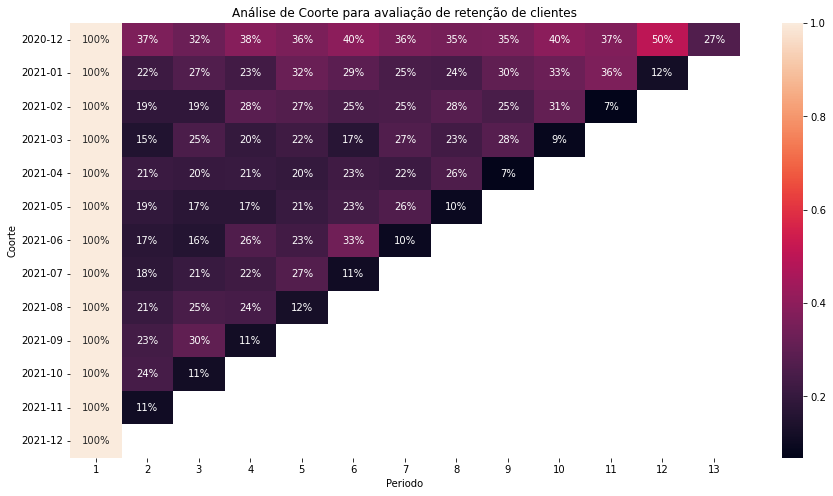

In [6]:
# calculando a retenção dos clientes com a função criando_coorte
retencao_clientes = criando_coorte(df)

#Aplicando o gráfico no dataframe gerado para visualizar a retenção
sns.color_palette("rocket", as_cmap=True)
plt.figure(figsize=(15,8))
plt.title('Análise de Coorte para avaliação de retenção de clientes')
sns.heatmap(retencao_clientes.T, mask=retencao_clientes.T.isnull(), annot=True, fmt='.0%')

<AxesSubplot:title={'center':'Análise de Coorte para avaliação de retenção de clientes que são do Reino Unido'}, xlabel='Periodo', ylabel='Coorte'>

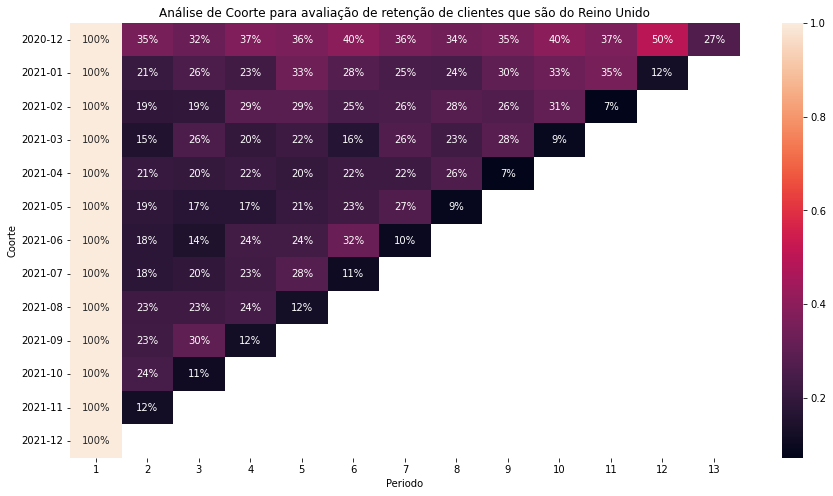

In [7]:
df_coorte_UK = df[df['Pertence_UK']=='SIM'].copy()

# calculando a retenção dos clientes com a função criando_coorte
retencao_clientes_UK = criando_coorte(df_coorte_UK)

#Aplicando o gráfico no dataframe gerado para visualizar a retenção
sns.color_palette("rocket", as_cmap=True)
plt.figure(figsize=(15,8))
plt.title('Análise de Coorte para avaliação de retenção de clientes que são do Reino Unido')
sns.heatmap(retencao_clientes_UK.T, mask=retencao_clientes_UK.T.isnull(), annot=True, fmt='.0%')

<AxesSubplot:title={'center':'Análise de Coorte para avaliação de retenção de clientes que não são do Reino Unido'}, xlabel='Periodo', ylabel='Coorte'>

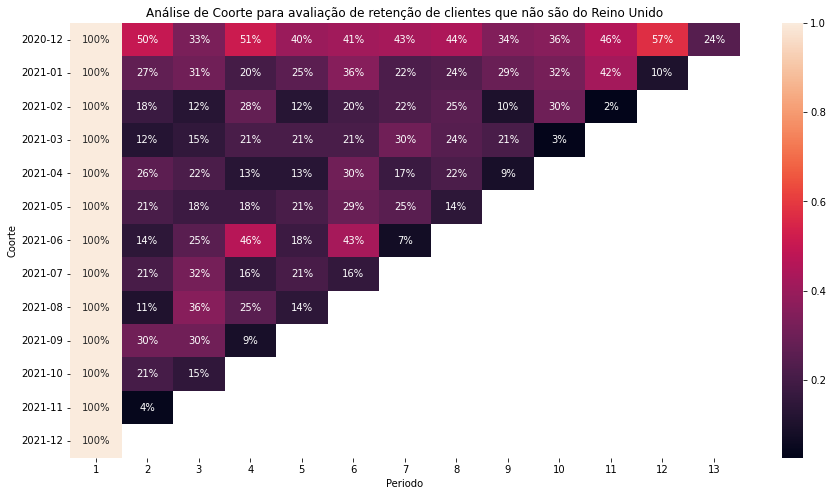

In [8]:
df_coorte_nao_UK = df[df['Pertence_UK']=='NÃO'].copy()

# calculando a retenção dos clientes com a função criando_coorte
retencao_clientes_nao_UK = criando_coorte(df_coorte_nao_UK)

#Aplicando o gráfico no dataframe gerado para visualizar a retenção
sns.color_palette("rocket", as_cmap=True)
plt.figure(figsize=(15,8))
plt.title('Análise de Coorte para avaliação de retenção de clientes que não são do Reino Unido')
sns.heatmap(retencao_clientes_nao_UK.T, mask=retencao_clientes_nao_UK.T.isnull(), annot=True, fmt='.0%')